# BACKTRADER Tutorial

A. Create a Strategy:

1. Decide on potential adjustable parameters
2. Instantiate the Indicators you need in the Strategy
3. Write down the logic for entering/exiting the market

B. Create a Cerebro (brain in Spanish) Engine

1. Inject the Strategy (or signal-based strategy)
2. Load and Inject a Data Feed (once created use cerebro.adddata)
3. Add writer, analyzer and observer
4. Execute cerebro.run()
For visual feedback use: cerebro.plot()

### Line concepts
Each line is essentially a container for times series data points (iterator object), which can be updated at every step of the backtest. For example, when you create a custom indicator, you define a line to store the computed values. Data Feeds, Indicators and Strategies have lines. Basically everything (even operators/functions operate on iterables: if -> IF(), and -> And()) gets transformed into an object which can be used as a data feed once it has been operated upon in __init__. \
To speed up operations, Indicators support a batch operation mode which has been termed as runonce. It is not strictly needed (a next method suffices) but it greatly reduces time. (preonce, oncestart and once methods)

Lines are called by self.datas[X].Name

It makes no sense to try to make decisions if the indicator is not yet ready and producing values. The first few bars will be removed from the backtest. For example, if you use a Moving Average (SMA) with a period of 20 bars, the strategy will call *prenext* method until 20 bars are available. The *nextstart* method is called exactly once when the minimum period for the line iterator has been met.
lines.get(ago=-1, size=10), ago is the staring point to look backwards 10 values.

Instead of manually comparing the previous close value to the actual value of a SMA in each next iteration: (*delay*) notation can be used. self.cmpval = self.data.close(-1) > self.sma: delivers a replica of the close prices but delayed by -1. In next(): if self.cmpval[0]:\
WITHOUT providing a *delay* value, then a LinesCoupler lines object is returned. This is meant to establish a coupling between indicators that operate on datas with different timeframes. self.buysig = sma0 > sma1() 1 is weekly data and 0 is daily data.

The first data in the list self.datas[0] is the default data for trading operations and to keep all strategy elements synchronized (it’s the system clock). If data feeds of different timeframes (and thus different bar counts) are passed the next method will be called for the master data (the 1st one passed to cerebro) which must be the the data with the smaller timeframe. The datas must be properly date-time aligned.\
When data is only available in a single timeframe and the analysis has to be done for a different timeframe, it’s time to do some resampling.\
Replay a daily bar using the 1 minute data.\
Please notice that there is no “time” or “timeframe” implied: number of bars. The bars can represent 1 minute, 1 hour, 1 day, 1 week or any other time period.

### Notes
Rounding has an effect on the results: The Yahoo Data Feed allows to specify if rounding has to happen and how many decimals.

The current value is accessed with index: 0 (think of it as the value of the current bar)
And the “last” output value (think of it as the value of the previous bar) is accessed with -1

call len on an object and it will tell you the length of its lines. Just write down (save in a variable) at which length in an operation took place and see if the current length is 5 bars away.

If net profit is not equal to the broker final value then we need to check open positions on the last day of the Data Feed that have not been executed. The “Final Portfolio Value” calculated by the broker takes into account the “Close” price on the final day of the Data Feed.

For Futures check: Data-Feed Rollover and Futures and Spot Compensation

### Things to know
Methods buy and sell return the created (not yet executed) order

Changes in orders’ status will be notified to the strategy via a notify method. \
If data feeds and/or brokers send notifications (or a store provider which creates them) they will be received through the Cerebro.notify_store

What asset is being bought. getposition(data=None, broker=None)

How are orders being executed?\
The order is executed “At **Market**”. The broker executes this using the opening price of the next bar, because that’s the 1st tick after the current under examination bar. When the data feeds deliver the new set of bars (next method), those bars are closed. This means the data has already happened. \
**Close** Using the close price of the next bar when the next bar actually closes.\
**Limit** The price set at order creation if the data touches it, starting with the next price bar:
For Buy Orders
Case 1:
If the open price of the bar is below the limit price the order executes immediately with the open price. The order has been swept during the opening phase of the session
Case 2:
If the open price has not penetrated below the limit price but the low price is below the limit price, then the limit price has been seen during the session and the order can be executed
The logic is obviously inverted for Sell orders.\
**Stop** loss
For Stop orders which Buy
Case 1:
If the open price of the bar is above the stop price the order is executed immediately with the open price.
Intended to stop a loss if the price is moving upwards against an existing short position
Case 2:
If the open price has not penetrated above the stop price but the high price is above the stop price, then the stop price has been seen during the session and the order can be executed
The logic is obviously inverted for Stop orders which Sell.\
**StopLimit** order is a combination of a stop order and a limit order. Once the stop price is hit, it turns into a limit order instead of a market order. This helps control the price at which the order is filled but also risks not getting filled if the market moves too quickly past the limit price. \
If one has entered the market long by issuing a buy, this is what a sell with **StopTrail** does:
If no price is specified, the latest close price is used 
*trailamount* is substracted from the price to find the stop (or trigger) price
The next iteration of the broker checks if the trigger price has been reached
    If Yes: the order is executed with a Market execution type approach
    If No, the stop price is recalculated by using the latest close price and substracting the trailamount distance
    If the new price goes up, it is updated
    If the new price would go down (or not change at all), it remains fixed to potentially secure a profit.\
For a **StopTrailLimit**: the order is executed as a Limit order when the trailing stop price is triggered.\
**Bracket Order** long side is formed of \
A main side buy order, usually set to be a Limit or StopLimit order\
A low side sell order, usually set to be a Stop order to limit losses\
A high side sell order, usually set to be a Limit order to take profit \
The 3 orders are submitted together to avoid having any of them triggered independently
The low/high side orders are marked as children of the main side
The children are not active until the main side is executed
The cancellation of the main side cancels both the low and high side
The execution of the main side activates both the low and high side
Upon being active: The execution or cancellation of any of low/high side orders automatically cancels the other

order status

position sizer (how many shares are being bought)

slippage

Commission margin and leverage (Check CommissionInfo methods)

To use **ML**:
1. load the ML model and the scaler in the __init__ function
2. Create a predict function
    A. get the data necessary for the model
    B. Transform it
    C. Predict the variables of interest
    D. Rescale the values
    E. Return the values to be used for placing orders

### Analysers

The Analyzer base class creates a self.rets (of type collections.OrderedDict) member attribute to return the analysis. This is done in the method create_analysis which can be overriden by subclasses if creating custom analyzers.

get_analysis: which ideally (not enforced) returnes a dict -like object containing the analysis results. pprint (pretty print) uses the Python pprint module to print the get_analysis results (The default behaviour is to create a OrderedDict named rets).

During execution it works by gathering information in the notify_xxx and next methods, and generating the current information of the analysis in next, but generates the analysis in a single pass during the stop method.

# Import Libraries

In [1]:
import backtrader as bt
import yfinance as yf
import quantstats as qs
import datetime
# import pytz
from colorama import Fore, Style
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

# Data Feeds

In [2]:
# Exchanges use close prices for official trading records, while adjusted close prices are used for accurate historical analysis.
spy = yf.download("SPY", start="2020-01-01", end="2022-02-02").xs("SPY", axis=1, level=1)
data_feed = bt.feeds.PandasData(dataname=spy,
                                timeframe=bt.TimeFrame.Days,
                                compression=1, # Number of actual bars per bar. each n bars become a bar 
                                name='SPY',
                                tz='UTC' # Data feed timezone
                                # * Settings for out-of-sample data
                                # fromdate=datetime.datetime(2018, 1, 1),
                                # todate=datetime.datetime(2019, 12, 25))
                                )

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Strategy with simple orders

In [3]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    # It would a bit unpractical to hardcode some of the values in the strategy 
    # and have no chance to change them easily. Parameters come in handy to help.
    # (tuple of tuples or dict-like object)
    params = {
            'exitbars': 3,
            # "stake": 10,
            # 'maperiod': 15,
            'printlog': False,
        }

    def log(self, txt, dt=True, color="WHITE", bold=False, italic=False, doprint=False):
        ''' Logging function with colorama colors, bold, and italic styles '''
        if self.params.printlog or doprint:
            
            # Choose color
            color = getattr(Fore, color.upper(), Fore.WHITE)
            
            # Add bold and italic styles
            style = ""
            if bold:
                style += "\033[1m"  # ANSI code for bold
            if italic:
                style += "\033[3m"  # ANSI code for italic (may not work on all terminals)
            
            # Create the formatted log message
            log_message = f"{self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d %H:%M:%S')} | {txt}" if dt else txt
            
            # Print the log message with color and styles, and reset all afterward
            print(style + color + log_message + Style.RESET_ALL)

    def __init__(self):
        # Keep a reference to the "close" line in the datas[0] dataseries
        # self.data targets self.datas[0] or self.data0 or self.data.lines[0]
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        
        # To keep track of pending orders 
        self.orefs = list()

        #* Follow bits of an orders
        self.bit=0

        # Get the list of trades
        self.trades=[]

        #* Add indicators
        # self.sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.maperiod)

        #* Plot lines objects from operations
        # LinePlotterIndicator(close_over_sma, name='Close_over_SMA')

        # * Set the sizer stake from the params
        # self.sizer.setsizing(self.params.stake)
        # * We could have also called buy and sell with a stake parameter

        #* Add a timer to trigger at a certain time
        # UTC (default behavior)
        # Add a timer for New York session open (9:30 AM US/Eastern) ny_timezone  = pytz.timezone('US/Eastern')
        # self.timer = self.add_timer(
        #     when=datetime.time(9, 30), # or bt.timer.SESSION_START 
        #     offset=datetime.timedelta(minutes=15), # Trigger at 09:45 AM
        #     repeat=datetime.timedelta(days=1),  # Repeat every day
        #     weekdays=[1, 2, 3, 4, 5],  # Trigger Monday to Friday
        # )

        #* If different assets require similar indicators, create a dictionary during initialization to map each data feed to its respective indicator.
        # self.indicators = {}
        # for d in self.datas:
        #     self.indicators[d] = {}
        #     self.indicators[d]['sma'] = bt.indicators.SimpleMovingAverage(d.close, period=20)

    def format_execution_details(self, order, tabular=True):
        """
        Comprehensive formatter for Backtrader order execution details.
        
        Args:
            order: Backtrader order object
            tabular: If True, formats output in a tabular format
        
        Returns:
            str: Formatted execution details
        """
        
        # Prepare execution details
        exec_details = []         

        if order.executed.exbits[self.bit].opened != 0:
            exbit = order.executed.exbits[self.bit]
            # Opened Position Details
            opened_entry = {
                "Bit": self.bit,
                "Opened Size": exbit.opened,
                "Opened Price": f"{exbit.price:.4f}",
                "Opened Value": f"{exbit.openedvalue:.2f}", # Opened Size*Opened Price
                "Opened Commission": f"{exbit.openedcomm:.4f}",
                "Current Cum Open Position Size": exbit.psize,
                "Current Position Average Price": f"{exbit.pprice:.4f}" # [sum of the (size * price)] / total size
            }
            exec_details.append(opened_entry)
            self.bit +=1

        else:
            exbit = order.executed.exbits[self.bit]
            # Closed Position Details
            closed_entry = {
                "Bit": self.bit,
                "Closed Size": exbit.closed,
                "Closed Price": f"{exbit.price:.4f}",
                "Closed Value": f"{exbit.closed*exbit.price:.2f}", # exbit.closedvalue = Closed Size*Opened Position Average Price
                "Closed Commission": f"{exbit.closedcomm:.4f}",
                "PNL": f"{exbit.pnl:.2f}", # (Closed Price - Opened Position Average Price)*Closed Size for Open Buy orders and vice versa for Open Sell orders
                "Remaining Positions to Close Size": exbit.psize,
                "Opened Position Average Price": f"{exbit.pprice:.4f}"
            }
            exec_details.append(closed_entry)
            self.bit +=1
        
        # Tabular output
        if tabular:
            try:
                return tabulate(
                    [list(d.values()) for d in exec_details], 
                    headers=list(exec_details[0].keys()), 
                    tablefmt="pretty"
                )
            except ImportError:
                # Fallback to formatted string if tabulate is not available
                tabular = False
        
        # Formatted string output if not tabular
        if not tabular:
            output = []
            for detail in exec_details:
                for key, value in detail.items():
                    output.append(f"{key}: {value}")
                output.append("-" * 40)
            return "\n".join(output)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            self.log('{} {} {} ORDER {} {} | Price: {:<8.2f} | PriceLimit: {:<8.2f}{}| Size: {:<8.2f} | Margin: {:<8.2f}'.format(
                order.data._name,
                'BUY' * order.isbuy() or 'SELL',   
                order.getordername(),  
                order.ref,  
                order.getstatusname(),
                order.created.price,  # Execution price
                order.created.pricelimit or 0.0,  # Price limit for StopLimit orders
                " | TrailAmount: {:<4.2f} ".format(order.created.trailamount) if order.created.trailamount is not None else (" | TrailPercent: {:<2.3f} ".format(order.created.trailpercent) if order.created.trailpercent is not None else ' '),
                order.created.size,  # Requested/executed size
                order.created.margin or 0.0,  # Margin incurred by the order
            ), color="yellow" * order.issell() or "cyan")
            return

        # Handle partial fills
        if order.status in [bt.Order.Partial]:
            self.log('{} {} ORDER {} {}'.format(
                                    'BUY' * order.isbuy() or 'SELL',
                                    order.getordername(),
                                    order.ref,
                                    order.getstatusname()), color="yellow" * order.issell() or "cyan")
            # Average fill price is the [sum of the (size * price)] / total size
            print(f"Filled {order.executed.size} units until now at an average price of {order.executed.price}.")
            # remaining_size = order.size - order.executed.size
            print(f"Remaining order size: {order.executed.remsize} units.") 
            print(" Execution bit details:")
            print(self.format_execution_details(order, tabular=True) ) 
            return

        # Check if an order has been completed i.e. sent to the exchange
        if order.status in [order.Completed]:

            if self.bit!=0:
                self.log(
                    '{} {} ORDER {} {} | Average Price: {:<8.2f} | Size: {:<7.2f} | Value: {:<9.2f} | Total Comm: {:<8.2f}'.format(
                        'BUY' * order.isbuy() or 'SELL',
                        order.getordername(),
                        order.ref,
                        order.getstatusname(),
                        order.executed.price,
                        order.executed.size,
                        order.executed.size*order.executed.price,
                        order.executed.comm
                    ),
                    color="yellow" * order.issell() or "cyan",  # Highlight sell orders in yellow and buy orders in cyan
                    bold=True
                )
                print("Last execution bit details:")
                print(self.format_execution_details(order, tabular=True) ) 
                
            else:
                order_type = 'SELL' * order.issell() or 'BUY'
                self.log(
                    '{} {} {} ORDER {} {} | Executed Price: {:<8.2f} | Size: {:<7.2f} | Value: {:<9.2f} | Comm: {:<8.2f}'.format(
                        order.data._name,
                        order_type,
                        order.getordername(),
                        order.ref,
                        order.getstatusname(),
                        order.executed.price,
                        order.executed.size,
                        order.executed.price*order.executed.size,
                        order.executed.comm
                    ),
                    color="yellow" * order.issell() or "cyan",  # Highlight sell orders in yellow and buy orders in cyan
                    bold=True
                )

            self.bar_executed = len(self)
            self.bit =0
            

        # Handle rejected orders
        elif order.status == bt.Order.Rejected:
            self.log('{} {} {} ORDER {} {}'.format(
                                                order.data._name,
                                                'BUY' * order.isbuy() or 'SELL',
                                                order.getordername(),
                                                order.ref,
                                                order.getstatusname()), color="yellow" * order.issell() or "cyan", bold=True)
            # The reason for rejection will be sent via the notify_store method

        # Handle margin call
        elif order.status == bt.Order.Margin:
            self.log('{} {} {} ORDER {} {} would imply a margin call (not enough cash to execute the order).'.format(
                                                order.data._name,
                                                'BUY' * order.isbuy() or 'SELL',
                                                order.getordername(),
                                                order.ref,
                                                order.getstatusname()), color="yellow" * order.issell() or "cyan", bold=True)
        
        # Handle order cancellation
        elif order.status in [order.Canceled, bt.Order.Cancelled]:
            self.log('{} {} {} ORDER {} {} by the user.'.format(
                                                order.data._name,
                                                'BUY' * order.isbuy() or 'SELL',
                                                order.getordername(),
                                                order.ref,
                                                order.getstatusname()), color="yellow" * order.issell() or "cyan", bold=True)  

        elif order.status == bt.Order.Expired:
            self.log('{} {} {} ORDER {} has {} time validity'.format(
                                                order.data._name,
                                                'BUY' * order.isbuy() or 'SELL',
                                                order.getordername(),
                                                order.ref,
                                                order.getstatusname()), color="yellow" * order.issell() or "cyan", bold=True)
        
        # returns bool if order is in status Partial or Accepted
        if not order.alive() and order in self.orefs: 
            self.orefs.remove(order)
        
    def notify_store(self, msg):
        print(f"Broker notification: {msg}")

    def notify_trade(self, trade):
        status = {
            trade.Created: "Created", 
            trade.Open: "Open", 
            trade.Closed: "Closed"
        }.get(trade.status, "Unknown")
        
        if trade.isclosed:
            self.log(f"Trade Reference: {trade.ref} | ID {trade.tradeid} | Instrument: {trade.data._name if trade.data else 'N/A'} | Status: {status} \nTrade Details:", dt=False, bold=True, color="red" if trade.pnlcomm < 0 else "green")
            self.log(f"Duration {bt.num2date(trade.dtclose)-bt.num2date(trade.dtopen)} | Held during {trade.barlen} Bars | Gross PNL: {trade.pnl:.4f} | Total Commission: {trade.commission:.4f} | Net PNL: {trade.pnlcomm:.4f}",dt=False, bold=True, color="red" if trade.pnlcomm < 0 else "green")
            self.trades.append(trade)
            
        elif trade.isopen:
            self.log(f"Trade Reference: {trade.ref} | ID {trade.tradeid} | Instrument: {trade.data._name if trade.data else 'N/A'} | Status: {status}", dt=False, italic=True)
        

    def notify_fund(self, cash, value, fundvalue, shares):
        # Value - it's the sum of your cash and the current market value of all your open positions at the close of each bar.
        self.log('Open: {:<6.4f} | Close {:<6.4f} | Cash: {:<9.2f} | Value: {:<9.4f} | Fund Value: {:<9f} | Shares: {:<9.2f}'
                 .format(self.dataopen[0], self.dataclose[0], cash, value, fundvalue, shares))
    
    def notify_timer(self, timer, when):
        # This function is called when the timer is triggered
        self.log(f"Timer triggered at {when}", doprint=True)
    def nextstart(self):
        print("--------------------------------------------------")
        print("Bars Passed to account for the lookback period of indicators: ", len(self))
        print("--------------------------------------------------")

        super(TestStrategy, self).nextstart()
    def next(self):
        # self.log('data {:<6.2f}'.format(self.datas[0].get))
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.orefs:
            return
        
        # Check if we are in the market?
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                # current close less than previous close

                if self.dataclose[-1] < self.dataclose[-2]:
                    # previous close less than the previous close

                    # BUY, BUY, BUY!!! (with default parameters)
                    # Keep track of the created order to avoid a 2nd order
                    self.orefs.append(self.buy(data=self.datas[0], size=None, # None can be taken from getsizer 
                                            #  amount of shares, contracts in the portfolio of a specific asset
                                            price=None, # None is valid for Market and Close orders | trigger point for Limit, Stop, 'Stop'Limit and 'Stop'TrailLimit
                                            plimit= None, # ex. self.data.close[0] * 1.02, Only applicable to Stop'Limit' or StopTrail'Limit' orders.
                                            exectype=bt.Order.Market or None, # bt.Order.Close can be used to execute at the second next close
                                            valid=None, # Good till cancel
                                                        # Order.DAY or 0 for Day orders
                                                        # datetime.datetime or datetime.date: Good till date
                                            # oco="anotherorder", # One cancel others: If any order in the group is executed, cancelled or expires, the other orders will be cancelled
                                            trailamount=None, # for Order.Stop'Trail' or Stop'Trail'Limit
                                            trailpercent=None, # for Order.Stop'Trail' or Stop'Trail'Limit
                                            # for manual bracket order creation
                                            parent=None, # The low/high side orders must have parent=main_side_order
                                            transmit=True # The main_side order must be created 1st and have transmit=False
                                                          # 1st low/high side order must have transmit=False
                                                          # The last order to be created (either the low or high side) sets transmit=True
                                                          # Specify the execution types and low/high side order size=main_side.size
                                        ))
                    self.log('{} {} {} ORDER {} Created'.format(
                                    self.orefs[0].data._name,
                                    'BUY' * self.orefs[0].isbuy() or 'SELL',
                                    self.orefs[0].getordername(),
                                    self.orefs[0].ref), color="yellow" * self.orefs[0].issell() or "cyan", italic=True)
                    # self.broker.submit(order)

        # self.close(data=None, size=None, **kwargs same as buy) # submits the opposite order to close the current open position, regardless of whether it's long or short.

        else:

            # Already in the market ... we might sell
            # Exit after 5 bars (on the 6th bar) have elapsed for good or for worse
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                # Keep track of the created order to avoid a 2nd order
                self.orefs.append(self.sell(data=self.datas[0], 
                                       size=self.position.size,
                                       price=None, 
                                       plimit= None, 
                                       exectype=bt.Order.Market or None, 
                                       valid=None, 
                                       oco=None,
                                       trailamount=None, 
                                       trailpercent=None, 
                                       parent=None, 
                                       transmit=True
                                       ))
                self.log('{} {} {} ORDER {} Created'.format(
                                self.orefs[0].data._name,
                                'BUY' * self.orefs[0].isbuy() or 'SELL',
                                self.orefs[0].getordername(),
                                self.orefs[0].ref), color="yellow" * self.orefs[0].issell() or "cyan", italic=True)
    
    def order_target_xxx(self,data=None, target=0, **kwargs):
        """ 
        Perfect for portfolio rebalancing strategies

        xxx can be replaced by:
        1. size -> amount of shares, contracts in the portfolio of a specific asset

        2. value -> value in monetary units of the asset in the portfolio:
            current price of the asset multiplied by the current position size. 
            data_value = self.broker.get_value([self.datas[0]])

        3. percent -> percentage (from current portfolio) value of the asset in the current portfolio
        
        Specify the final target and the method decides if an operation will be a buy or a sell. 

        1. If the target is greater than the position_size: a buy is issued, with the difference target - position_size and vice versa

        2. The logic for order_target_percent is the same as that of order_target_value.
        If target > value and size >=0 -> buy
        If target > value and size < 0 -> sell
        If target < value and size >= 0 -> sell
        If target < value and size < 0 -> buy

        EXAMPLES:
        # Example: If your portfolio is $100,000 and you have 10% in this asset but want 5%
        self.order_target_percent(data=self.data, target=0.05)  # Will sell to reduce to $5,000
        # Example: If your position is worth $10,000 and you want to exit
        self.order_target_value(data=self.data, target=0)      # Will sell entire position
        # Example: If you have 50 shares and want to have 100 shares
        self.order_target_size(data=self.data, target=100)  # Will buy 50 more shares

        It returns either:
        The generated order
        or
        None if no order has been issued (target == position.size)
        """
        return super().order_target_xxx(data, target, **kwargs)
    
    def cancel(self, order):
        """Cancels the order in the broker"""
        return super().cancel(order)
    
    def stop(self):
        #* for optimization
        # self.log('(Exit bars %2d) Ending Value %.2f' %
        #             (self.params.exitbars, self.broker.getvalue()), doprint=True)
        print('Backtesting is finished with Portfolio Value: %.2f' % self.broker.getvalue(),"$")
    
    def start(self):
        print('Backtesting is about to start with Portfolio Value: %.2f' % self.broker.getvalue(),"$")
        # self.broker.add_cash(float(input("Enter amount of cash to Add/Remove i.e. +/-: "))) 

# Strategy with Bracket Orders (stop loss and take profit)

In [ ]:
class TestStrategy(bt.Strategy):

    params = {
            'printlog': False,
            'risk_percentage': 0.02,
            "stake":70
        }

    def log(self, txt, dt=None, color="WHITE", bold=False, italic=False, doprint=False):
        ''' Logging function with colorama colors, bold, and italic styles '''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.datetime(0)  # Get the full datetime object
            
            # Choose color
            color = getattr(Fore, color.upper(), Fore.WHITE)
            
            # Add bold and italic styles
            style = ""
            if bold:
                style += "\033[1m"  # ANSI code for bold
            if italic:
                style += "\033[3m"  # ANSI code for italic (may not work on all terminals)
            
            # Create the formatted log message
            log_message = f"{dt.strftime('%Y-%m-%d %H:%M:%S')} | {txt}"
            
            # Print the log message with color and styles, and reset all afterward
            print(style + color + log_message + Style.RESET_ALL)

    def __init__(self):
        # Keep a reference to the "close" line in the datas[0] dataseries
        # self.data targets self.datas[0] or self.data0 or self.data.lines[0]
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.atr = bt.indicators.ATR()
        
        # To keep track of pending orders 
        self.orefs = list()
        self.trades=[]


    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            self.log('{} {} {} ORDER {} {} | Price: {:<8.2f} | PriceLimit: {:<8.2f}{}| Size: {:<8.2f} | Margin: {:<8.2f}'.format(
                order.data._name,
                'BUY' * order.isbuy() or 'SELL',   
                order.getordername(),  
                order.ref,  
                order.getstatusname(),
                order.created.price,  # Execution price
                order.created.pricelimit or 0.0,  # Price limit for StopLimit orders
                " | TrailAmount: {:<4.2f} ".format(order.created.trailamount) if order.created.trailamount is not None else (" | TrailPercent: {:<2.3f} ".format(order.created.trailpercent) if order.created.trailpercent is not None else ' '),
                order.created.size,  # Requested/executed size
                order.created.margin or 0.0,  # Margin incurred by the order
            ), color="yellow" * order.issell() or "cyan")
            return

        # Handle partial fills
        if order.status in [bt.Order.Partial]:
            self.log('{} {} ORDER {} {}'.format(
                                    'BUY' * order.isbuy() or 'SELL',
                                    order.getordername(),
                                    order.ref,
                                    order.getstatusname()), color="yellow" * order.issell() or "cyan")
            print(f"Filled {order.executed.size} units at {order.executed.price}")

            for exbit in order.executed.exbits:
                # Each "exbit" is an instance of OrderExecutionBit containing execution details
                print(f"Execution detail: Price: {exbit.price} | Size: {exbit.size}")
                print(f"Closed: {exbit.closed} | Opened: {exbit.opened}")
                print(f"Opened Value: {exbit.openedvalue} | Closed Value: {exbit.closedvalue}")
                print(f"PNL: {exbit.pnl} | Commission: {exbit.comm}")

            # remaining_size = order.size - order.executed.size
            print(f"Remaining order size: {order.executed.remsize}")   

        # Check if an order has been completed i.e. sent to the exchange
        if order.status in [order.Completed]:
            order_type = 'SELL' * order.issell() or 'BUY'
            self.log(
                '{} {} {} ORDER {} {} | Price: {:<8.2f} | Size: {:<7.2f} | Value: {:<9.2f} | Comm: {:<8.2f}'.format(
                    order.data._name,
                    order_type,
                    order.getordername(),
                    order.ref,
                    order.getstatusname(),
                    order.executed.price,
                    order.executed.size,
                    order.executed.value,
                    order.executed.comm
                ),
                color="yellow" * order.issell() or "cyan",  # Highlight sell orders in yellow and buy orders in cyan
                bold=True
            )
            

        # Handle rejected orders
        elif order.status == bt.Order.Rejected:
            self.log('{} {} ORDER {} {}'.format(
                                                'BUY' * order.isbuy() or 'SELL',
                                                order.getordername(),
                                                order.ref,
                                                order.getstatusname()), color="yellow" * order.issell() or "cyan", bold=True)
            # The reason for rejection will be sent via the notify_store method

        # Handle margin call
        elif order.status == bt.Order.Margin:
            self.log('{} {} ORDER {} {} would imply a margin call (not enough cash to execute the order).'.format(
                                                'BUY' * order.isbuy() or 'SELL',
                                                order.getordername(),
                                                order.ref,
                                                order.getstatusname()), color="yellow" * order.issell() or "cyan", bold=True)
        
        # Handle order cancellation
        elif order.status in [order.Canceled, bt.Order.Cancelled]:
            self.log('{} {} ORDER {} {}'.format(
                                                'BUY' * order.isbuy() or 'SELL',
                                                order.getordername(),
                                                order.ref,
                                                order.getstatusname()), color="yellow" * order.issell() or "cyan", bold=True)

        elif order.status == bt.Order.Expired:
            self.log('{} {} ORDER {} has {} time validity'.format(
                                                'BUY' * order.isbuy() or 'SELL',
                                                order.getordername(),
                                                order.ref,
                                                order.getstatusname()), color="yellow" * order.issell() or "cyan", bold=True)
        
        # returns bool if order is in status Partial or Accepted
        if not order.alive() and order in self.orefs: 
            self.orefs.remove(order)
        
    def notify_store(self, msg):
        print(f"Broker notification: {msg}")

    def notify_trade(self, trade):
        status = {
            trade.Created: "Created", 
            trade.Open: "Open", 
            trade.Closed: "Closed"
        }.get(trade.status, "Unknown")
        
        if trade.isclosed:
            self.log(f"Trade Reference: {trade.ref} | ID {trade.tradeid} | Instrument: {trade.data._name if trade.data else 'N/A'} | Status: {status} \nTrade Details:", dt=False, bold=True, color="red" if trade.pnlcomm < 0 else "green")
            self.log(f"Duration {bt.num2date(trade.dtclose)-bt.num2date(trade.dtopen)} | Held during {trade.barlen} Bars | Gross PNL: {trade.pnl:.4f} | Total Commission: {trade.commission:.4f} | Net PNL: {trade.pnlcomm:.4f}",dt=False, bold=True, color="red" if trade.pnlcomm < 0 else "green")
            self.trades.append(trade)
            
        elif trade.isopen:
            self.log(f"Trade Reference: {trade.ref} | ID {trade.tradeid} | Instrument: {trade.data._name if trade.data else 'N/A'} | Status: {status}", dt=False, italic=True)

    def notify_fund(self, cash, value, fundvalue, shares):
        self.log('Open: {:<6.4f} | Close {:<6.4f} | Cash: {:<9.2f} | Value: {:<9.2f} | Fund Value: {:<9f} | Shares: {:<9.2f}'.format(self.dataopen[0], self.dataclose[0], cash, value, fundvalue, shares))
    
    def notify_timer(self, timer, when):
        # This function is called when the timer is triggered
        self.log(f"Timer triggered at {when}")

    def next(self):

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.orefs:
            return
        
        # Check if we are in the market?
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                # current close less than previous close

                if self.dataclose[-1] < self.dataclose[-2]:
                    # previous close less than the previous close

                    # BUY, BUY, BUY!!! (with default parameters)
                    # Returns a list containing the 3 orders in this order: [main, stop, limit] limit as take profit and stop as stop loss
                    # If high/low orders have been suppressed the return value will still contain 3 orders, but those suppressed will have a value of None
                    close = self.data.close[0]
                    p1 = close #* (1.0 - 0.005)
                    p2 = p1 - 0.02 * close
                    p3 = p1 + 0.1 * close 
                    valid1 = datetime.timedelta(3)
                    valid2 = valid3 = datetime.timedelta(500)
                    self.orefs=[o for o in self.buy_bracket(data=None, 
                                     size=None, # The same size is applied to all 3 orders of the bracket
                                     price=p1,
                                     plimit=None, 
                                     exectype=0, # Default 2 or bt.Order.Limit
                                     valid=valid1, 
                                     tradeid=0, 
                                     trailamount=None, 
                                     trailpercent=None, 
                                     oargs={}, 
                                     stopprice=p2, # Specific price for the *low side* stop order 
                                     stopexec=3, # default bt.Order.Stop
                                     stopargs=dict(valid=valid2), 
                                     limitprice=p3, # Specific price for the *high side* stop order
                                     limitexec=2, # Default bt.Order.Limit
                                     limitargs={'valid':valid3},)]
                    # self.orefs = [o for o in os] 
                    self.log('{} {} {} ORDER {} Created'.format(
                                    self.orefs[0].data._name,
                                    'BUY' * self.orefs[0].isbuy() or 'SELL',
                                    self.orefs[0].getordername(),
                                    self.orefs[0].ref), color="yellow" * self.orefs[0].issell() or "cyan", italic=True)
                    # self.broker.submit(order)

        # self.close() # submits the opposite order to close the current open position, regardless of whether it's long or short.
                                     
    
    def stop(self):
        #* for optimization
        # self.log('(Exit bars %2d) Ending Value %.2f' %
        #             (self.params.exitbars, self.broker.getvalue()), doprint=True)
        print('Backtesting is finished with Portfolio Value: %.2f' % self.broker.getvalue(),"$")
    
    def start(self):
        print('Backtesting is about to start with Portfolio Value: %.2f' % self.broker.getvalue(),"$")
        # self.broker.add_cash(float(input("Enter amount of cash to Add/Remove i.e. +/-: "))) 

# Analyzers

In [ ]:
def AddAnalyzers(cerebro):
    # A trade is defined as opening a position and taking the position back to 0.
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='Trades')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return', timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
    # Add Analyzer for SQN
    # SquareRoot(NumberTrades) * Average(TradesProfit) / StdDev(TradesProfit)
    # The sqn value should be deemed reliable when the number of trades >= 30
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    #* Pyfolio
    # cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    # # In Main
    # portfolio_stats = results[0].analyzers.getbyname('PyFolio')
    # returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
    
    return cerebro

# SQN Categorization Function
def categorize_sqn(sqn_value):
    if sqn_value < 1.6:
        return "Poor"
    elif 1.6 <= sqn_value < 2.0:
        return "Below Average"
    elif 2.0 <= sqn_value < 2.5:
        return "Average"
    elif 2.5 <= sqn_value < 3.0:
        return "Good"
    elif 3.0 <= sqn_value <= 5.0:
        return "Excellent"
    elif 5.1 <= sqn_value <= 6.9:
        return "Superb"
    elif sqn_value >= 7.0:
        return "Holy Grail?"
    else:
        return "Unknown"

# Sizers

In [5]:
class CustomSizer(bt.Sizer):
    params = (('stake', 1),)

    def _getsizing(self, comminfo, cash, data, isbuy):
        """
        `comminfo`: The CommissionInfo instance that contains
        information about the commission for the data and allows
        calculation of position value, operation cost, commision for the
        operation
        
        This method returns the desired size (absolute) for the buy/sell operation.
        If 0 is returned nothing will be executed.
        """
        # position = self.strategy.getposition(data) # can use self.broker
        # size = self.p.stake * (1 + (position.size != 0)) # double the stake

        risk_amount = cash * self.strategy.p.risk_percentage
        atr_value = self.strategy.atr[0]
        current_price = self.strategy.data.close[0] 
        if atr_value:
            position_size = risk_amount / (atr_value*current_price)
            return int(position_size)
        return self.strategy.p.stake
    
# PercentSizer() This sizer return percents of available cash

# Observers

In [6]:
class BuySell(bt.observers.BuySell):
    plotlines = dict(
        buy=dict(marker='^', markersize=8.0, color='lime', fillstyle='full'),
        sell=dict(marker='v', markersize=8.0, color='red', fillstyle='full')
    )

class Trades(bt.observers.Trades):
    plotlines = dict(
        pnlplus=dict(_name='Positive',
                    marker='o', color='blue',
                    markersize=4.0, fillstyle='full'),
        pnlminus=dict(_name='Negative',
                    marker='o', color='red',
                    markersize=4.0, fillstyle='full')
    )

# cerebro.addobserver(bt.observers.Broker)
#* Override BuySell and Trades
# cerebro.addobserver(BuySell)
# cerebro.addobserver(Trades)
# cerebro.run(stdstats=False)

# Main Cerebro

In [ ]:
initial_capital = 100000.0
if __name__ == '__main__':

    cerebro = bt.Cerebro() # Set optreturn=False to get full strategy objects instead of using OptReturn objects (which are more memory-efficient for large optimizations)

    #* Add a strategy + parameters
    idx = cerebro.addstrategy(TestStrategy, printlog=True) # ,risk_percentage=0.05
    
    #* Optimize a strategy (better used in .py file)
    # strats = cerebro.optstrategy(TestStrategy, exitbars=range(1, 5))
    # optimized_runs = cerebro.run(strats)
    # final_results_list = []
    # for run in optimized_runs:
    #     for strategy in run:
    #         PnL = round(strategy.broker.get_value() - 10000,2)
    #         sharpe = strategy.analyzers.sharpe_ratio.get_analysis()
    #         final_results_list.append([strategy.params.pfast, 
    #             strategy.params.pslow, PnL, sharpe['sharperatio']])

    # sort_by_sharpe = sorted(final_results_list, key=lambda x: x[3], 
    #                          reverse=True)
    
    #* Add the data feed to Cerebro
    cerebro.adddata(data_feed) 
    # cerebro.resampledata(data_feed, timeframe=bt.TimeFrame.Days)
    # * cerebro.replaydata(data_feed, timeframe=bt.TimeFrame.Days)
    # Intrabar Strategy Testing: Lets you test strategies that rely on intrabar movements, even if you're working with higher timeframe data (e.g., daily bars).
    # Simulating Real-Time Behavior: Mimics how a strategy would behave in live trading, where prices evolve during the formation of a bar.
    # * Create a chart with two price datafeeds overlaid on top of each other. 
    # data2.compensate(data1)  # let the system know ops on data1 affect data0
    # data2.plotinfo.plotmaster = data1
    # data2.plotinfo.sameaxis = True
    # cerebro.adddata(data2)

    #* Add position sizer
    cerebro.addsizer_byidx(idx, bt.sizers.FixedSize, stake=70)
    # cerebro.addsizer_byidx(idx, CustomSizer, stake=70)

    #* Commission 0.001 -> 0.1% ... divide by 100 to remove the %, commision rate per operation (both for buying and selling)
    cerebro.broker.setcommission(commission=0, # percentage of the price times size operation value
                                 # if margin is set then the commission is a fixed value which is multiplied by the size component of buy or sell operation
                                 margin=None, # Margin money needed when operating with futures like instruments.
                                 mult=1.0, # For future like instruments this determines the multiplicator to apply to profit and loss calculations.
                                 percabs=True, # for commission percentage: True: 0.XX, False: XX%                                  
                                 commtype=None, # (def: None) % or fixed monetary value
                                 # And margin=None, Internal _commtype is set to COMM_PERC and _stocklike is set to True
                                 # And margin is not None: _commtype set to COMM_FIXED and _stocklike set to False
                                 stocklike=False, # (def: False) Indicates if the instrument is Stock-like or Futures-like
                                 interest=0.0, # 0.05 -> 5%, yearly interest charged for holding a short selling position.
                                 # The formula: days * price * abs(size) * (interest / 365)
                                 # the behavior can be changed by overriding the method: _get_credit_interest
                                 interest_long=False, # Some products like ETFs get charged on interest for short and long positions.
                                 leverage=1.0, # Amount of leverage for the asset with regards to the needed cash
                                 automargin=False, # automatically calculate the margin/guarantees needed with the following policy:
                                 # Use param margin if param automargin evaluates to False
                                 # Use param mult and use mult * price if automargin < 0
                                 # Use param automargin and use automargin * price if automargin > 0
                                 # get_margin(price)
                                 name=None) # Limit the application of the commission scheme to instruments matching name

    #* Slippage 0.01 is 1%
    # slip prices up/down for buy/sell orders
    cerebro.broker.set_slippage_perc(0, # 0.01 is 1%
                                     slip_open=True, # Market & Stop order - Slippage is applied | Close orders - No slippage is applied
                                     slip_limit=True, # Limit orders will be matched by capping prices to the limit high/low prices
                                     # If False and slippage exceeds the cap, then there will be no match.
                                     slip_match=True, # Caps slippage to the high/low of the bar. If False, will try execution during the next iteration 
                                     # Limit orders, given the exact match price requested, will be matched with no slippage even if slip_match is False.
                                     slip_out=False # Provide slippage even if the price falls outside the high - low range.
                                     )
    # Configure slippage to be percentage based VS Fixed point based set_slippage_fixed(fixed, ...)

    #* Cheat on Open
    # The opening price gaps (up or down, depending on whether buy or sell is in effect) and the cash is not enough for an all-in operation.
    cerebro.broker.set_coo(False)

    #* Volume fillers : Default FixedSize()
    # cerebro.broker.set_filler(bt.broker.fillers.FixedBarPerc(perc=0.00001)) # Percentage of the volume bar to use to execute an order 
    
    #* Set the initial capital
    cerebro.broker.setcash(initial_capital)

    cerebro.broker.set_fundstartval(100.0)  # Initial fund value
    cerebro.broker.set_fundmode(False)  # Fund-style tracking: Performance calculated based on fund value
                                       # False for total portfolio net asset value NAV
                                       # Affects analyzers like TimeReturn
    cerebro.broker.set_int2pnl(True)  # Add Interest to P&L of position-reducing trades. Set to False for multi-strategy fairness.
    cerebro.broker.set_shortcash(True)  # Short selling cash handling, True: the cash increases, and the value of the asset becomes negative.

    #* Add a custom writer
    # cerebro.addwriter(CustomWriter,) #, csv=True

    #* An analyzer analyzes the performance of a single strategy and not the performance of an entire system
    cerebro = AddAnalyzers(cerebro)

    #* Observers are called at the end of the cycle … they observe what has happened and have lines
    # Observers can be accessed with self.stats.observers
    # Pass TimeFrame.NoTimeFrame to consider the entire dataset with no time constraints
    cerebro.addobserver(bt.observers.Benchmark, timeframe=bt.TimeFrame.NoTimeFrame, data=data_feed)
 
    #* loop over data
    results = cerebro.run(stdstats=True) # includes default Broker, Trades and BuySell Observers (to be plotted)

    returns = results[0].analyzers.time_return.get_analysis()
    returns = pd.Series(index=returns.keys(), data=returns.values())
    returns.name="returns"

    trades_netpnl = pd.Series([trade.pnlcomm for trade in results[0].trades],
                            index=[bt.num2date(trade.dtclose) for trade in results[0].trades])
    trades_netpnl.name="netpnl"


    #* Extract SQN Value
    sqn_analysis = results[0].analyzers.sqn.get_analysis()
    sqn_value = sqn_analysis['sqn']
    category = categorize_sqn(sqn_value)
    print(f"System Quality Number (SQN) is: {sqn_value:.2f} --> {category}")

    #* Quanstats Report
    # qs.reports.full(returns=returns, benchmark=spy["Close"].pct_change()) # full

    #* Plot the result
    # %matplotlib widget
    # plt.rcParams["figure.figsize"] = (11, 12)
    # cerebro.plot(plotter = None , numfigs=1, iplot=False) 
     # can add start=datetime.date(2005, 7, 1), end=datetime.date(2006, 1, 31)

Backtesting is about to start with Portfolio Value: 100000.00 $
2020-01-02 00:00:00 | Open: 299.0622 | Close 300.2916 | Cash: 100000.00 | Value: 100000.0000 | Fund Value: 100.000000 | Shares: 1000.00  
--------------------------------------------------
Bars Passed to account for the lookback period of indicators:  1
--------------------------------------------------
2020-01-03 00:00:00 | Open: 296.8623 | Close 298.0178 | Cash: 100000.00 | Value: 100000.0000 | Fund Value: 100.000000 | Shares: 1000.00  
2020-01-03 00:00:00 | SPY BUY Market ORDER 93 Created
2020-01-06 00:00:00 | SPY BUY Market ORDER 93 Submitted | Price: 298.02   | PriceLimit: 298.02   | Size: 70.00    | Margin: 0.00    
2020-01-06 00:00:00 | SPY BUY Market ORDER 93 Accepted | Price: 298.02   | PriceLimit: 298.02   | Size: 70.00    | Margin: 0.00    
2020-01-06 00:00:00 | SPY BUY Market ORDER 93 Completed | Executed Price: 296.24   | Size: 70.00   | Value: 20737.00  | Comm: 0.00    
Trade Reference: 47 | ID 0 | Instrument

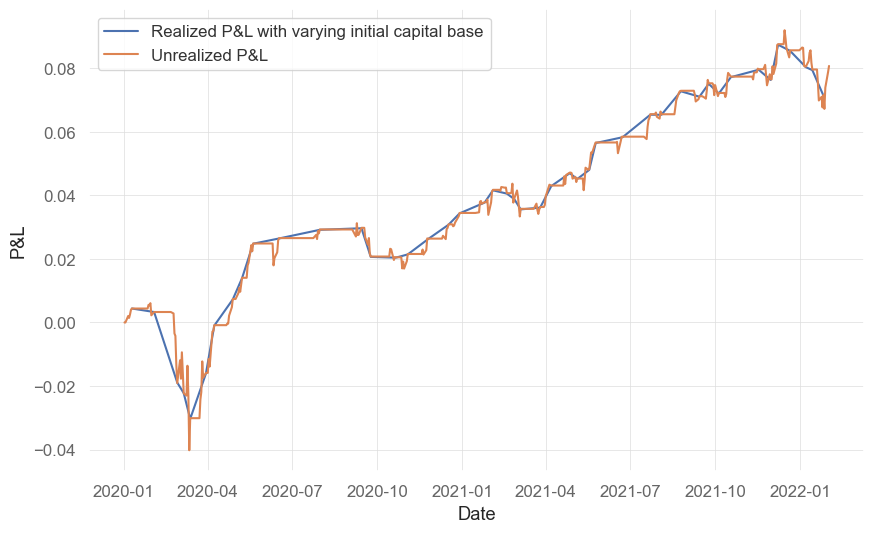

In [126]:

# #* The initial capital stays the same with each trade
# trades = pd.Series([initial_capital]+[trade.pnlcomm+initial_capital for trade in results[0].trades],
#           index=[initial_capital]+[bt.num2date(trade.dtclose) for trade in results[0].trades])
# trades.name="trades"
# trades=trades.pct_change().dropna().cumsum()
# #* The starting price always stays the same
# plt.plot(trades.cumsum(), label='Realized P&L with fixed initial capital base')

# * Changing the initial capital with each trade
trades = pd.Series([initial_capital]+[trade.pnlcomm for trade in results[0].trades],
          index=[initial_capital]+[bt.num2date(trade.dtclose) for trade in results[0].trades])
trades.name="trades"
trades=trades.cumsum().pct_change().dropna()
# * The starting price changes
plt.plot(trades.cumsum(), label='Realized P&L with varying initial capital base')


#* We are changing the base of the %change every time with the price change
plt.plot(returns.cumsum(), label='Unrealized P&L')

df = pd.merge(returns, trades, left_index=True, right_index=True, how='outer')
df = df.loc[:df["trades"].last_valid_index()]
df = df.fillna(0).cumsum()
# plt.plot(df["trades"], label='Realized P&L from another angle')

plt.xlabel('Date')
plt.ylabel('P&L')
plt.legend()
plt.show()


# Risk Management

In [ ]:
class RiskManagement:
    def __init__(self, trades_netpnl:pd.Series, initial_capital:int):
        self.realized_pnl = trades_netpnl
        self.capital = initial_capital
    
    def optimal_f(self) -> float:
        """
        Calculate Optimal f (fraction) to maximize long-term growth rate based on the Kelly Criterion
        
        Args:
            trades: List of historical trade results (profits/losses)
            
        Returns:
            Optimal fraction of capital to risk on each trade
        """
        worst_loss = abs(self.realized_pnl.min())  # Get absolute value of worst loss

        def TWR(f: float) -> float:
            """Terminal Wealth Relative - measures growth of account"""
            if f == 0: # no risk
                return 1.0 # no growth
            
            twr = 1.0
            for trade in self.realized_pnl:
                
                # Calculate HPR (Holding Period Return)
                hpr = 1 + (f * trade / worst_loss)
                    
                twr *= hpr
            return twr
        
        # Find f that maximizes TWR using numerical optimization
        f_values = np.linspace(0, 1, 1000)
        twr_values = [TWR(f) for f in f_values]
        optimal_f = f_values[np.argmax(twr_values)]
        
        return optimal_f
    
    @staticmethod
    def rv_risk_of_ruin(win_rate, avg_return_per_win, avg_return_per_loss, initial_capital, max_risk) -> float:
        """
        Calculate Ralph Vince Risk of Ruin based on trading statistics
        Taken from https://www.quantifiedstrategies.com/risk-of-ruin-in-trading/#How_to_calculate_the_risk_of_ruin
        
        For example, a result of 0.05 means there's a 5% chance of losing the specified percentage of capital (max_risk) over the long run.
        
        Args:
            max_risk: Fraction of capital you're prepared to lose before declaring ruin. (0.5 for 50% of capital.)
        
        Returns:
            Ralph Vince Risk of Ruin probability of losing a specific portion of trading capital
        """
        # probability of losing a trade
        loss_rate = 1 - win_rate
        
        # Calculate averageWin% and averageLoss%
        average_win_percentage = avg_return_per_win / initial_capital
        average_loss_percentage = avg_return_per_loss / initial_capital
        
        # Calculate Z (Expected Value: expected percentage return per trade)
        Z = (win_rate * average_win_percentage) - (loss_rate * average_loss_percentage)
        
        # Calculate A (Standard Deviation of returns)
        A = (
            win_rate * (average_win_percentage ** 2) - 
            loss_rate * (average_loss_percentage ** 2)
        )**0.5

        # Calculate P
        P = 0.5 * ((1 + Z) / A)
        
        # Calculate Risk of Ruin
        if P <= 0 or P >= 1:
            return 1.0  # Maximum risk of ruin

        # Calculate Risk of Ruin
        rv_risk_of_ruin = ((1 - P) / P) ** (max_risk/A)
        
        return rv_risk_of_ruin
    
    @staticmethod
    def pk_risk_of_ruin(win_rate, max_loss, initial_capital, max_risk) -> float:
        """
        Calculate Perry Kaufman Risk of Ruin based on trading statistics
        Taken from https://docs.google.com/spreadsheets/d/1DhuJnfLlnw4xl48Li8fdhn3bKT0JJNv5iLMJ0PfE_7Y/edit?gid=0#gid=0
        Args:
            max_risk: Fraction of capital you're prepared to lose before declaring ruin. (0.5 for 50% of capital.)
        
        Returns:
            Perry Kaufman Risk of Ruin probability of losing a specific portion of trading capital
        """
        # probability of losing a trade
        loss_rate = 1 - win_rate

        # Calculate Edge: If positive, the system has an advantage.
        edge = win_rate-loss_rate

        if edge<=0:
            return 1.0 # Maximum risk of ruin
        
        # Calculate inner term: odds against the trader.
        inner_term = (1-edge)/(1+edge)

        # The amount of capital that would constitute "ruin" if lost.
        risk_capital = initial_capital*max_risk

        # Ensure max_loss is negative and non-zero
        if max_loss >= 0:
            max_loss = -abs(max_loss)  # Convert to negative if positive

        if max_loss == 0:
            return 1.0  # Maximum risk of ruin if no loss limit is set
        
        # calculate the exponent term: how many consecutive maximum losses would lead to ruin.
        exp = risk_capital/-max_loss
        pk_risk_of_ruin = inner_term ** exp
    
        return pk_risk_of_ruin

    def calculate_equity_curve(self, trades):
        """
        Generate an equity curve based on the given sequence of trades.
        
        Args:
            trades (array-like): Sequence of trade profits/losses
        
        Returns:
            numpy.ndarray: Cumulative sum representing portfolio growth (true dollar values)
        """
        return np.cumsum(trades)+self.capital
    
    def calculate_max_drawdown(self, equity_curve):
        """
        Calculate the maximum drawdown from an equity curve.
        
        Args:
            equity_curve (array-like): Cumulative portfolio values
        
        Returns:
            float: Maximum drawdown percentage
        """
        if len(equity_curve) == 0:
            return 0
        
        peak = np.maximum.accumulate(equity_curve)
        drawdown = (peak - equity_curve) / peak
        return np.max(drawdown)*100

    def analyze_simulation(self, equity_curve):
        """
        Analyze the simulated equity curve for performance metrics.
        
        Args:
            equity_curve (array-like): Cumulative portfolio values
        
        Returns:
            dict: Performance metrics including max drawdown and final return
        """
        max_drawdown = self.calculate_max_drawdown(equity_curve)
        net_profit = equity_curve[-1]-self.capital
        return {
            "max_drawdown": max_drawdown, 
            "net_profit": net_profit
        }
    
    def calculate_confidence_interval(self, data, conf_level):
        """
        Calculate confidence interval for given data and confidence level.
        
        Args:
            data (list): Numerical data to analyze
            conf_level (float): Confidence level percentage
        
        Returns:
            tuple: (lower_bound, mean, upper_bound)
        """
        n = len(data)
        mean = np.mean(data)
        std_error = np.std(data, ddof=1) / np.sqrt(n)
        
        # Calculate t-value for given confidence level
        t_value = stats.t.ppf((1 + conf_level) / 2, df=n-1)
        
        # Calculate margin of error
        margin_of_error = t_value * std_error
        
        # Calculate confidence interval
        lower_bound = mean - margin_of_error
        upper_bound = mean + margin_of_error
        
        return lower_bound, mean, upper_bound
    
    def aggregate_results(self, results):
        """
        Aggregate results of all simulations into summary statistics.
        
        Args:
            results (list): List of simulation results
        
        Returns:
            dict: Summary statistics with confidence intervals
        """
        # Define confidence levels
        confidence_levels = [
            0.50, 0.60, 0.70, 0.80, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1
        ]

        drawdowns = [res["max_drawdown"] for res in results]
        returns = [res["net_profit"] for res in results]
        
        # Prepare table data
        table_data = []
        for conf_level in confidence_levels:
            # Calculate intervals for returns and drawdowns
            returns_stats = self.calculate_confidence_interval(returns, conf_level)
            drawdown_stats = self.calculate_confidence_interval(drawdowns, conf_level)
            
            # Create row for the table
            table_data.append([
                f"{conf_level*100}%",
                f"[{returns_stats[0]:.4f} - {returns_stats[1]:.2f} - {returns_stats[2]:.4f}]",
                f"[{drawdown_stats[0]:.4f} - {drawdown_stats[1]:.2f} - {drawdown_stats[2]:.4f}]"
            ])
        
        # Create and print the table
        headers = [
            "Confidence Level", 
            "Net Profit CI", 
            "Max Drawdown % CI"
        ]
        
        # Print the table using tabulate
        table = tabulate(
            table_data, 
            headers=headers, 
            tablefmt='pretty'
        )
        
        print(table)

    def simulate_trades(self, n_simulations=1000, fraction=1, replace=False):
        """
        Perform Monte Carlo simulation of trades.
        
        Args:
            n_simulations (int): Number of simulations to run
            replace (bool): Whether to sample with replacement
            fraction (float): Fraction of trades to simulate
        """
        # Validate input
        if self.realized_pnl.empty:
            raise ValueError("No trades have been added. Use add_trade() first.")
        
        results = []
        
        for _ in range(n_simulations):
            # Randomize the sequence of trades
            shuffled_trades = self.realized_pnl.sample(frac=fraction, replace=replace).reset_index(drop=True).values
            
            # Calculate equity curve for the randomized trade sequence
            equity_curve = self.calculate_equity_curve(shuffled_trades)
            
            # Analyze and store the results of this simulation
            results.append(self.analyze_simulation(equity_curve))
        
        # Aggregate results across all simulations
        self.aggregate_results(results)

# Trade Analytics

In [46]:
def generate_streaks(analysis):

    streaks = analysis['Streaks']
    streak_data = {
        'Streak Type': ['Current Win', 'Longest Win', 'Current Loss', 'Longest Loss'],
        'Streak Length': [
            streaks['Current Win Streak'],
            streaks['Longest Win Streak'],
            streaks['Current Loss Streak'],
            streaks['Longest Loss Streak']
        ]
    }

    # Horizontal bar plot
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['skyblue', 'blue', 'salmon', 'red']

    ax.barh(streak_data['Streak Type'], streak_data['Streak Length'], color=colors)
    ax.set_title('Win/Loss Streaks', fontsize=14)
    ax.set_xlabel('Length', fontsize=12)
    ax.set_ylabel('Streak Type', fontsize=12)

    # Annotate bars
    for index, value in enumerate(streak_data['Streak Length']):
        ax.text(value + 0.2, index, str(value), va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

def generate_won_lost_pie(analysis):
    won_trades = analysis['Won Trades']['Total']
    lost_trades = analysis['Lost Trades']['Total']

    # Calculate percentages
    long_won_percent = analysis['Long Trades']['Won']['Total'] / won_trades * 100
    short_won_percent = analysis['Short Trades']['Won']['Total'] / won_trades * 100
    long_lost_percent = analysis['Long Trades']['Lost']['Total'] / lost_trades * 100
    short_lost_percent = analysis['Short Trades']['Lost']['Total'] / lost_trades * 100

    # Pie chart data
    won_sizes = [long_won_percent, short_won_percent]
    lost_sizes = [long_lost_percent, short_lost_percent]
    labels = ['Long Trades', 'Short Trades']

    # Plot pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Won Trades Pie Chart
    axes[0].pie(won_sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
    axes[0].set_title(f' {won_trades} Won Trades Distribution', fontsize=14)

    # Lost Trades Pie Chart
    axes[1].pie(lost_sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
    axes[1].set_title(f'{lost_trades} Lost Trades Distribution', fontsize=14)

    plt.tight_layout()
    plt.show()

def generate_won_lost_length_chart(analysis):
    # Extract data
    won_lengths = analysis['Trade Lengths']['Won Trades Length']
    lost_lengths = analysis['Trade Lengths']['Lost Trades Length']

    # Prepare data for bar chart
    categories = ['Total', 'Average', 'Max Length', 'Min Length']
    won_values = [round(won_lengths[cat],3) for cat in categories]
    lost_values = [round(lost_lengths[cat],3) for cat in categories]

    # Create the bar chart
    x = np.arange(len(categories))  # x-axis positions
    width = 0.35  # Bar width

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars for won and lost trades
    bars1 = ax.bar(x - width/2, won_values, width, label='Won Trades', color='skyblue')
    bars2 = ax.bar(x + width/2, lost_values, width, label='Lost Trades', color='salmon')

    # Add labels and title
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Bars', fontsize=12)
    ax.set_title('Comparison of Won vs. Lost Trades Lengths', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=10)
    ax.legend(fontsize=10)

    # Annotate bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def generate_long_short_chart(analysis):
    # Extract data for bar chart comparison
    categories = ['Total PnL', 'Average PnL']
    long_values = [round(analysis['Long Trades']['PnL']['Total'], 3), round(analysis['Long Trades']['PnL']['Average'], 3)]
    short_values = [round(analysis['Short Trades']['PnL']['Total'], 3), round(analysis['Short Trades']['PnL']['Average'], 3)]

    # Create the bar chart
    x = np.arange(len(categories))  # x-axis positions
    width = 0.35  # Bar width

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars for long and short trades
    bars1 = ax.bar(x - width/2, long_values, width, label='Long Trades', color='skyblue')
    bars2 = ax.bar(x + width/2, short_values, width, label='Short Trades', color='salmon')

    # Add labels and title
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.set_title('Comparison of Long vs. Short Trades PnL', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=10)
    ax.legend(fontsize=10)

    # Annotate bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Detailed breakdown for Won and Lost trades comparison
    won_categories = ['Total PnL', 'Average PnL', 'Max PnL']
    long_won_values = [
        round(analysis['Long Trades']['Won']['PnL']['Total'], 3),
        round(analysis['Long Trades']['Won']['PnL']['Average'], 3),
        round(analysis['Long Trades']['Won']['PnL']['Max PnL'], 3)
    ]
    short_won_values = [
        round(analysis['Short Trades']['Won']['PnL']['Total'], 3),
        round(analysis['Short Trades']['Won']['PnL']['Average'], 3),
        round(analysis['Short Trades']['Won']['PnL']['Max PnL'], 3)
    ]

    lost_categories = ['Total PnL', 'Average PnL', 'Max PnL']
    long_lost_values = [
        round(analysis['Long Trades']['Lost']['PnL']['Total'], 3),
        round(analysis['Long Trades']['Lost']['PnL']['Average'], 3),
        round(analysis['Long Trades']['Lost']['PnL']['Max PnL'], 3)
    ]
    short_lost_values = [
        round(analysis['Short Trades']['Lost']['PnL']['Total'], 3),
        round(analysis['Short Trades']['Lost']['PnL']['Average'], 3),
        round(analysis['Short Trades']['Lost']['PnL']['Max PnL'], 3)
    ]

    # Create separate bar charts for won and lost trades
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Won Trades
    x_won = np.arange(len(won_categories))
    bars1_won = axes[0].bar(x_won - width/2, long_won_values, width, label='Long Trades', color='skyblue')
    bars2_won = axes[0].bar(x_won + width/2, short_won_values, width, label='Short Trades', color='salmon')
    axes[0].set_title('Won Trades PnL', fontsize=14)
    axes[0].set_xticks(x_won)
    axes[0].set_xticklabels(won_categories, fontsize=10)
    axes[0].legend(fontsize=10)

    # Annotate Won Trades bars
    for bars in [bars1_won, bars2_won]:
        for bar in bars:
            height = bar.get_height()
            axes[0].annotate(f'{height}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)

    # Lost Trades
    x_lost = np.arange(len(lost_categories))
    bars1_lost = axes[1].bar(x_lost - width/2, long_lost_values, width, label='Long Trades', color='skyblue')
    bars2_lost = axes[1].bar(x_lost + width/2, short_lost_values, width, label='Short Trades', color='salmon')
    axes[1].set_title('Lost Trades PnL', fontsize=14)
    axes[1].set_xticks(x_lost)
    axes[1].set_xticklabels(lost_categories, fontsize=10)
    axes[1].legend(fontsize=10)

    # Annotate Lost Trades bars
    for bars in [bars1_lost, bars2_lost]:
        for bar in bars:
            height = bar.get_height()
            axes[1].annotate(f'{height}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


In [47]:
def format_trade_analysis(trade_analyzer):
    analysis = {
        'Total Trades': trade_analyzer['total']['total'],
        'Open Trades': trade_analyzer['total']['open'],
        'Closed Trades': trade_analyzer['total']['closed'],
        
        'Streaks': {
            'Current Win Streak': trade_analyzer['streak']['won']['current'],
            'Longest Win Streak': trade_analyzer['streak']['won']['longest'],
            'Current Loss Streak': trade_analyzer['streak']['lost']['current'],
            'Longest Loss Streak': trade_analyzer['streak']['lost']['longest']
        },
        
        'PnL': {
            'Gross PnL': {
                'Total': trade_analyzer['pnl']['gross']['total'],
                'Average': trade_analyzer['pnl']['gross']['average']
            },
            'Net PnL': {
                'Total': trade_analyzer['pnl']['net']['total'],
                'Average': trade_analyzer['pnl']['net']['average']
            }
        },
        
        'Won Trades': {
            'Total': trade_analyzer['won']['total'],
            'PnL': {
                'Total': trade_analyzer['won']['pnl']['total'],
                'Average': trade_analyzer['won']['pnl']['average'],
                'Max PnL': trade_analyzer['won']['pnl']['max']
            }
        },
        
        'Lost Trades': {
            'Total': trade_analyzer['lost']['total'],
            'PnL': {
                'Total': trade_analyzer['lost']['pnl']['total'],
                'Average': trade_analyzer['lost']['pnl']['average'],
                'Max PnL': trade_analyzer['lost']['pnl']['max']
            }
        },
        
        'Long Trades': {
            'Total': trade_analyzer['long']['total'],
            'PnL': {
                'Total': trade_analyzer['long']['pnl']['total'],
                'Average': trade_analyzer['long']['pnl']['average']
            },
            'Won': {
                'Total': trade_analyzer['long']['won'],
                'PnL': {
                    'Total': trade_analyzer['long']['pnl']['won']['total'],
                    'Average': trade_analyzer['long']['pnl']['won']['average'],
                    'Max PnL': trade_analyzer['long']['pnl']['won']['max']
                }
            },
            'Lost': {
                'Total': trade_analyzer['long']['lost'],
                'PnL': {
                    'Total': trade_analyzer['long']['pnl']['lost']['total'],
                    'Average': trade_analyzer['long']['pnl']['lost']['average'],
                    'Max PnL': trade_analyzer['long']['pnl']['lost']['max']
                }
            }
        },
        
        'Short Trades': {
            'Total': trade_analyzer['short']['total'],
            'PnL': {
                'Total': trade_analyzer['short']['pnl']['total'],
                'Average': trade_analyzer['short']['pnl']['average']
            },
            'Won': {
                'Total': trade_analyzer['short']['won'],
                'PnL': {
                    'Total': trade_analyzer['short']['pnl']['won']['total'],
                    'Average': trade_analyzer['short']['pnl']['won']['average'],
                    'Max PnL': trade_analyzer['short']['pnl']['won']['max']
                }
            },
            'Lost': {
                'Total': trade_analyzer['short']['lost'],
                'PnL': {
                    'Total': trade_analyzer['short']['pnl']['lost']['total'],
                    'Average': trade_analyzer['short']['pnl']['lost']['average'],
                    'Max PnL': trade_analyzer['short']['pnl']['lost']['max']
                }
            }
        },
        
        'Trade Lengths': {
            'Total Bars': trade_analyzer['len']['total'],
            'Average Length': trade_analyzer['len']['average'],
            'Max Length': trade_analyzer['len']['max'],
            'Min Length': trade_analyzer['len']['min'],
            
            'Won Trades Length': {
                'Total': trade_analyzer['len']['won']['total'],
                'Average': trade_analyzer['len']['won']['average'],
                'Max Length': trade_analyzer['len']['won']['max'],
                'Min Length': trade_analyzer['len']['won']['min']
            },
            
            'Lost Trades Length': {
                'Total': trade_analyzer['len']['lost']['total'],
                'Average': trade_analyzer['len']['lost']['average'],
                'Max Length': trade_analyzer['len']['lost']['max'],
                'Min Length': trade_analyzer['len']['lost']['min']
            }
        }
    }
    # Display the formatted analysis
    # for key, value in analysis.items():
    #     if isinstance(value, dict):
    #         print(f"{key}:")
    #         for sub_key, sub_value in value.items():
    #             print(f"  {sub_key}: {sub_value}")
    #     else:
    #         print(f"{key}: {value}")

    return analysis


		Overall Trade Analysis
************************************************************
Total Trades: 46
Remaining Open Trades: 1
Total Bars: 180
Average Trade Time: 4.0
Total Gross P&L: 7294.417384338765
Total Fees: 0.0
Average Net Return per any trade: 162.098164096417


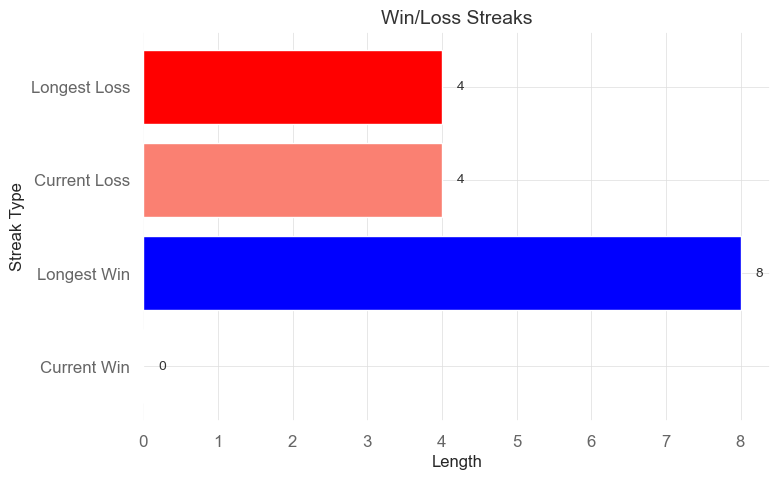

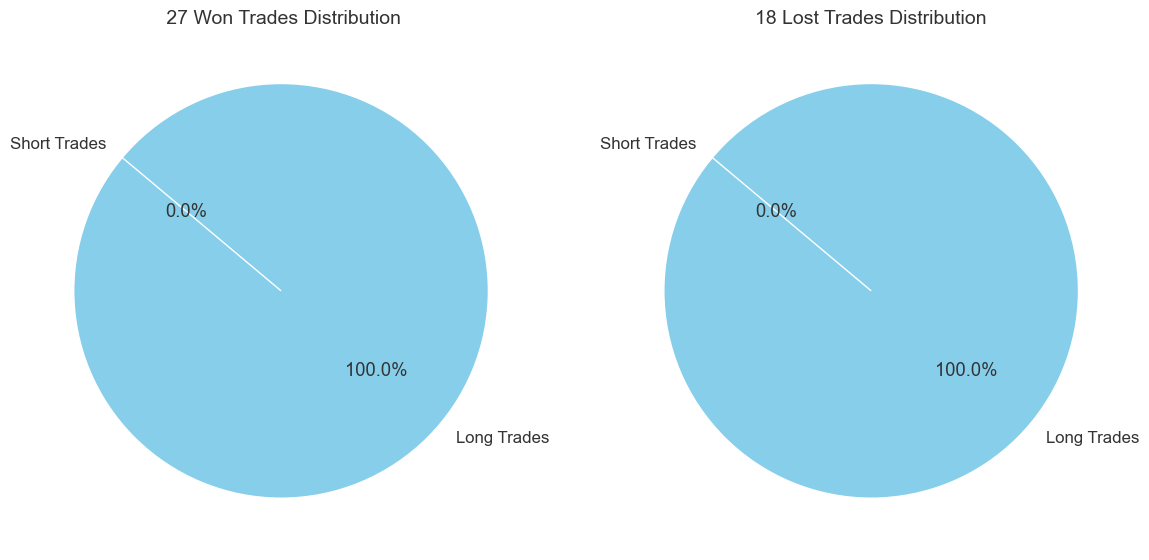

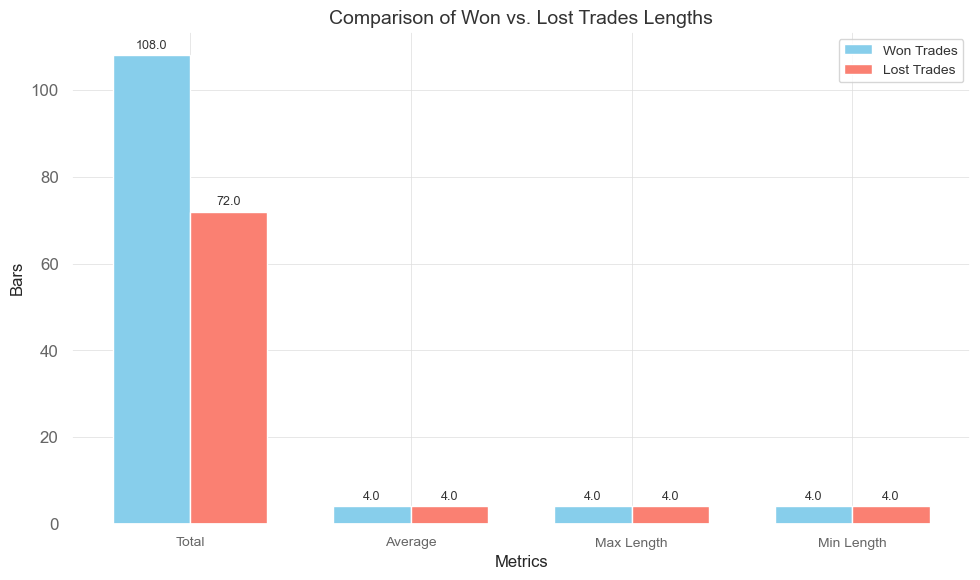

Max Drawdown Duration without weekends and holidays (in bars): 4


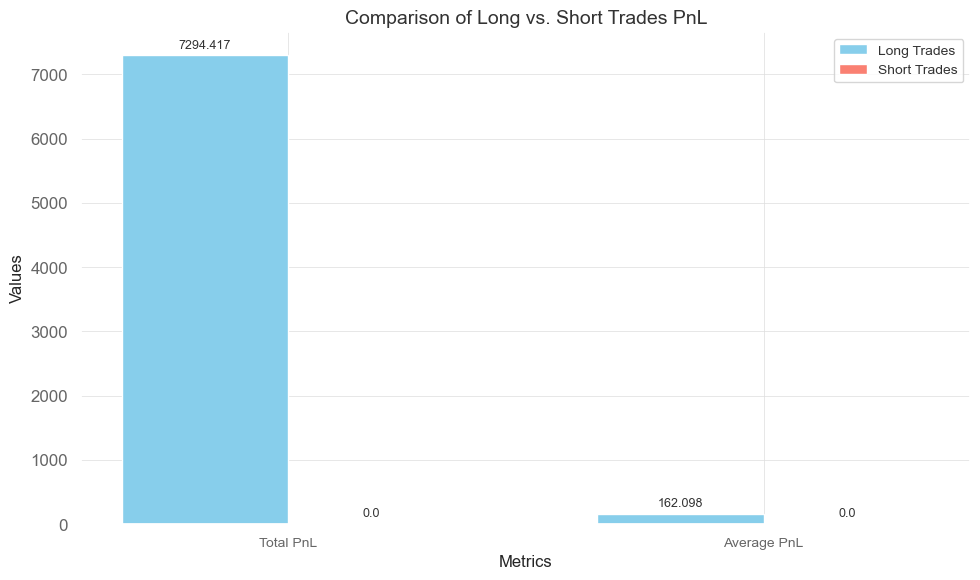

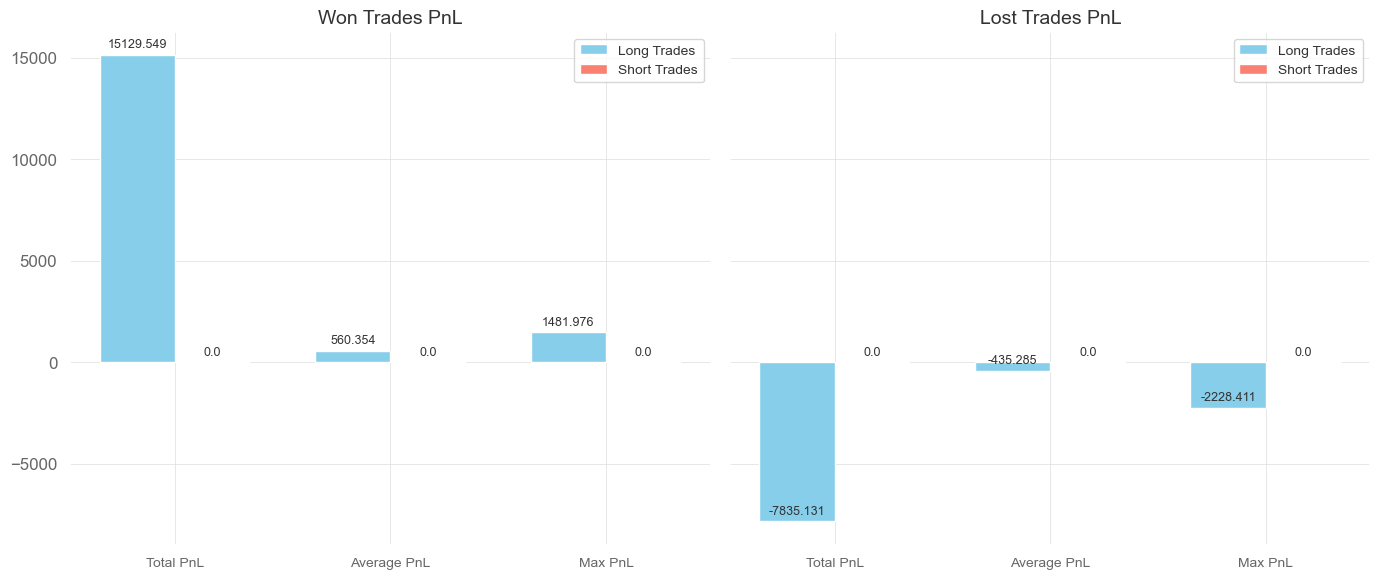

		Trade Statistics
************************************************************
Win Rate: 60.00%
Profit Factor: 1.9309885138970013
Profit to Loss Ratio: 1.287325675931334
Expectancy: 162.09816409641712
Risk to Reward Ratio: 1.5036759446787378
Optimal fraction to bet: 61.161%
Perry Kaufman's Risk of Ruin: 0.011%
Ralph Vince's Risk of Ruin: 100.000%

		Monte Carlo Simulation
************************************************************
+------------------+-----------------------------------+--------------------------+
| Confidence Level |           Net Profit CI           |    Max Drawdown % CI     |
+------------------+-----------------------------------+--------------------------+
|      50.0%       | [5847.7755 - 5887.44 - 5927.1111] | [2.4497 - 2.47 - 2.4847] |
|      60.0%       | [5837.9430 - 5887.44 - 5936.9435] | [2.4454 - 2.47 - 2.4890] |
|      70.0%       | [5826.4795 - 5887.44 - 5948.4070] | [2.4404 - 2.47 - 2.4941] |
|      80.0%       | [5812.0508 - 5887.44 - 5962.8358] | [2

In [127]:
def generate_statistics(raw_analysis, trades_netpnl, initial_capital, max_risk=0.2):
    """
    Capital Fraction: Fraction of capital at risk, expressed as X% of capital.
    """
    analysis = format_trade_analysis(raw_analysis)
    # Total Trades and Direction
    total_trades = analysis['Total Trades']
    remaining_open_trades = analysis['Open Trades']

    won_trades = analysis['Won Trades']['Total']
    closed_trades = analysis['Closed Trades']
    # Win Rate
    # percentage of winning trades, measures the proportion of trades that generate a profit.
    win_rate = won_trades / closed_trades if closed_trades > 0 else 0
    loss_rate = 1 - win_rate  # Complement of win rate
    
    # Profit Factor
    # total profit generated by winning trades to the total loss incurred by losing trades.
    net_winning_profit = analysis['Won Trades']['PnL']['Total']
    net_losing_loss = -analysis['Lost Trades']['PnL']['Total']  # Losses are negative in most implementations
    profit_factor = net_winning_profit / net_losing_loss if net_losing_loss != 0 else float('inf')
    
    # Average Return per Trade
    avg_return_per_win = analysis['Won Trades']['PnL']['Average'] # total profit made by winning trades / the number of winning trades
    avg_return_per_loss = analysis['Lost Trades']['PnL']['Average'] # total loss made by losing trades / the number of losing trades
    
    # Profit to loss Ratio
    profit_to_loss_ratio = avg_return_per_win / -avg_return_per_loss if avg_return_per_loss != 0 else float('inf')
    
    # Expectancy
    expectancy = (win_rate * avg_return_per_win) - (loss_rate * abs(avg_return_per_loss))

    # Max Win and Max Loss
    max_win = analysis['Won Trades']['PnL']['Max PnL']
    max_loss = analysis['Lost Trades']['PnL']['Max PnL']

    # Risk to Reward Ratio
    risk_to_reward_ratio = abs(max_loss / max_win) if max_win != 0 else float('inf')

    # * Risk Management
    risk_management = RiskManagement(trades_netpnl, initial_capital)
    # Perry Kaufman's Risk of Ruin
    perry_ror = risk_management.pk_risk_of_ruin(win_rate, max_loss, initial_capital, max_risk)   

    # Ralph Vince's Risk of Ruin
    ralph_ror = risk_management.rv_risk_of_ruin(win_rate, avg_return_per_win, avg_return_per_loss, initial_capital, max_risk)

    # Optimal F
    optimal_f = risk_management.optimal_f()
    
    # Summary of statistics
    general_statistics = {
        "Total Trades": total_trades,
        "Remaining Open Trades": remaining_open_trades,
        "Total Bars": analysis['Trade Lengths']['Total Bars'],
        "Average Trade Time": analysis['Trade Lengths']['Average Length'],
        "Total Gross P&L" : analysis["PnL"]["Gross PnL"]['Total'],
        "Total Fees" : analysis["PnL"]["Gross PnL"]['Total']-analysis["PnL"]["Net PnL"]['Total'],
        "Average Net Return per any trade": analysis["PnL"]["Net PnL"]['Average'],
    }

    print("\t\tOverall Trade Analysis")
    print("*"*60)
    for key, value in general_statistics.items():
        print(f"{key}: {value}")

    generate_streaks(analysis)
    generate_won_lost_pie(analysis)
    generate_won_lost_length_chart(analysis)
    print("Max Drawdown Duration without weekends and holidays (in bars):", analysis['Trade Lengths']['Lost Trades Length']['Max Length'])
    generate_long_short_chart(analysis)

    print("\t\tTrade Statistics")
    print("*"*60)
    statistics = {
        "Win Rate": f"{win_rate:.2%}",
        "Profit Factor": profit_factor,
        "Profit to Loss Ratio": profit_to_loss_ratio,
        "Expectancy": expectancy,
        "Risk to Reward Ratio": risk_to_reward_ratio,
        "Optimal fraction to bet" : f"{optimal_f:.3%}",
        "Perry Kaufman's Risk of Ruin": f"{perry_ror:.3%}",
        "Ralph Vince's Risk of Ruin": f"{ralph_ror:.3%}",
    }
    
    for key, value in statistics.items():
        print(f"{key}: {value}")

    print("\n\t\tMonte Carlo Simulation")
    print("*"*60)
    risk_management.simulate_trades(n_simulations=1000, fraction=0.8, replace=False)
   
generate_statistics(results[0].analyzers.Trades.get_analysis(), trades_netpnl, initial_capital, max_risk=0.5)

# Commissions

In [ ]:
class CommEurostoxx50(bt.CommInfoBase):
    params = dict(stocklike=True,
                  commtype=bt.CommInfoBase.COMM_PERC, # Apply % Commission
                  percabs=True, # pass perc as 0.xx
    
                # Custom params for the discount
                discount_volume=5000,  # minimum contracts to achieve discount
                discount_perc=50.0)  # 50.0% discount

    def _getcommission(self, size, price, pseudoexec):
        '''Calculates the commission of an operation at a given price

        pseudoexec: if True the operation has not yet been executed.
        A broker offers a 50% discount on futures round-trip commission once the amount of negotiated contracts has exceeeded 5000 units
        Before an order is executed, Backtrader may call _getcommission multiple times to:
        Estimate available cash after execution.
        Simulate what would happen to ensure constraints are met (e.g., margin requirements, commission affordability) for an order.
        The pseudoexec flag differentiates between actual executions (pseudoexec=False) and these preparatory calculations (pseudoexec=True). 
        Without pseudoexec, state changes like updating negotiated_volume would occur during pre-calculations, potentially causing:
        Overestimated trading volume.
        Premature triggering of the discount.
        '''
        if self.negotiated_volume > self.p.discount_volume:
           actual_discount = self.p.discount_perc / 100.0
        else:
           actual_discount = 0.0

        commission = self.p.commission * (1.0 - actual_discount)
        commvalue = size * price * commission

        if not pseudoexec:
           # keep track of actual real executed size for future discounts
           self.negotiated_volume += size

        return commvalue

    # If the broker doesn’t consider weekends or bank holidays when calculating the interest rate.
    def _get_credit_interest(self, size, price, days, dt0, dt1):
        # days: number of days elapsed since last credit calculation (this is (dt0 - dt1).days)
        return 1.0 * abs(size) * price * (self.p.interest / 365.0)
    
# cerebro.broker.addcommissioninfo(CommEurostoxx50(), name='Eurostoxx50')

# Writers

In [ ]:
class CustomWriter(bt.WriterFile):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    

# Indicators

In [ ]:
class MyIndicator(bt.Indicator):
    lines = ('overunder',)
    params = dict(period=20, movav=bt.indicators.MovAv.Simple) #* Backtrader built-in indicators
                                 # bt.talib.SMA(self.data, timeperiod=self.p.period) #* ta-lib indicators
    #* Object-wide plotting options
    plotinfo = dict(plot=True,
                subplot=False, # true for oscillators
                plotname='MyIndicator+',
                plotabove=False, # whether to plot above the data. Else plot below. Only if subplot is true.
                plotlinelabels=False, # whether to plot the names of the individudal lines along the data in the legend on the chart when subplot=False
                plotlinevalues=True, # the legend for the lines in Indicators and Observers has the last plotted value. per-line basis with _plotvalue for each line
                plotvaluetags=True, # value tag with the last value is plotted on the right hand side of the line. per-line basis with _plotvaluetag for each line
                plotymargin=0.15, # margin to add to the top and bottom of individual subcharts on the graph
                plotyticks=[20.0, 80.0], # value ticks to plot
                plothlines=[20.0, 50.0, 80.0], # horizontal lines to plot like overbought and oversold.
                plotyhlines=[], # This can take over both plothlines and plotyticks but they have precedence over the values present in this option
                plotforce=False, # This is a last resort mechanism to try to enforce plotting.
                plotmaster=None, # an Indicator/Observer has a master which is the data on which is working.
                plotylimited=True, # other lines on the data plot don’t change the scale.
           )
    
    #* Line specific plotting options
    # Plot the line "overunder" (the only one) with dash style
    # ls stands for linestyle and is directly passed to matplotlib
    plotlines = dict(
        # line = 
        overunder=dict(
            _name="OverUnder", #which changes the plot name of a specific line
            _method="plot", # or 'bar' which chooses the plotting method matplotlib will use for the element.
            # _fill_gt('another_line', ('red', 0.50)) # Allow filling between the given line and above: Another line or A numeric value
            ls='--', alpha=0.50, width=1.0 # other matplotlib args
            )
        )

    def _plotlabel(self):
        # This method returns a list of labels that will be displayed in between
        # parentheses after the name of the Indicators or Observer on the plot

        # The period must always be there
        plabels = [self.p.period]

        # Put only the moving average if it's not the default one
        plabels += [self.p.movav] * self.p.notdefault('movav')

        return plabels

    def __init__(self):
        movav = self.p.movav(self.data, period=self.p.period)
        self.l.overunder = bt.Cmp(movav, self.data)
    


class DummyInd(bt.Indicator):
    lines = ('dummyline',)

    params = (('value', 5),)

    def __init__(self):
        self.lines.dummyline = bt.Max(0.0, self.params.value)